In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [22]:
# video_path = r'AI数据样本\钢碗出粮（3种粮）+碗内余粮+积粮\1715676001789.mp4'
# video_path = r'AI数据样本\钢碗出粮（3种粮）+碗内余粮+积粮\1715676465056.mp4'
video_path = r'AI数据样本\钢碗出粮（3种粮）+碗内余粮+积粮\1715677386016.mp4'
capture = cv2.VideoCapture(video_path)

count = 0
frames = []
frame1, frame2 = None, None
while True:
    ret, frame = capture.read()
    count += 1
    if not ret:
        break
    if count % 100 == 0:
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    if count == 100:
        frame1 = frame
    if count == 1200:
        frame2 = frame
    elif count >= 5000:
        break
# frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
capture.release()

In [23]:
# cv2.imwrite('test.jpg', cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY))
mask = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

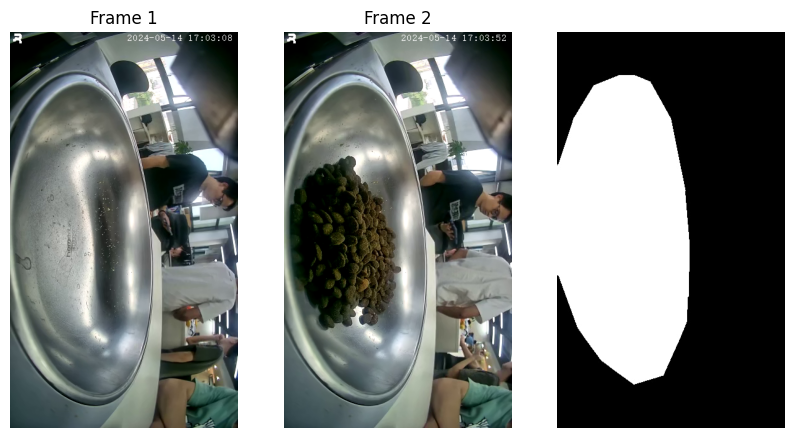

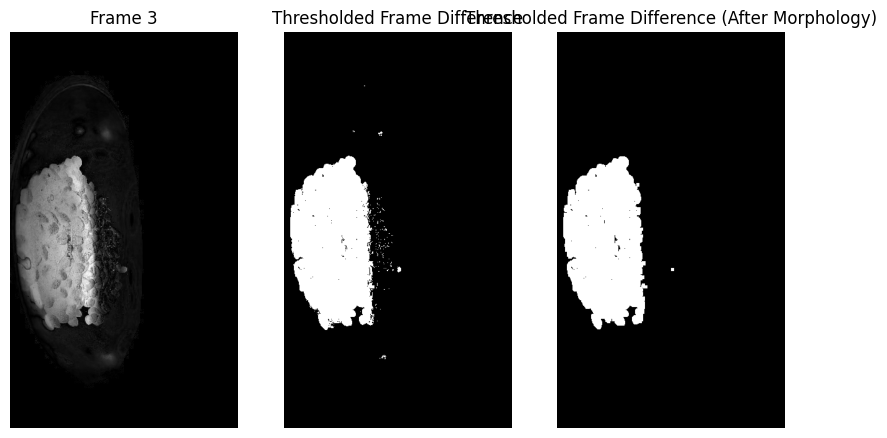

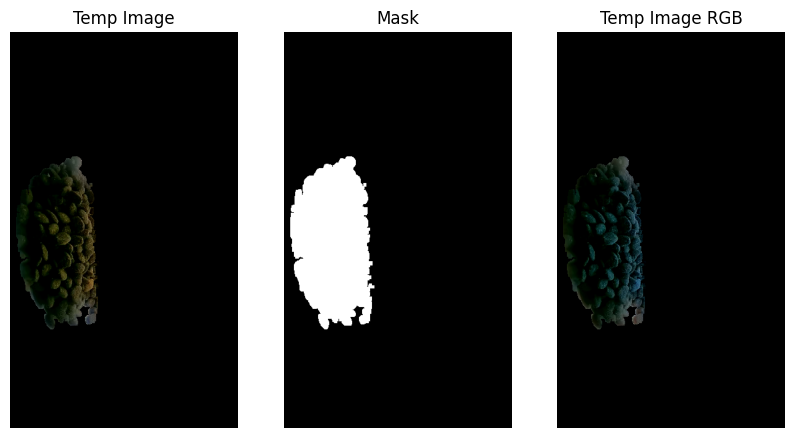

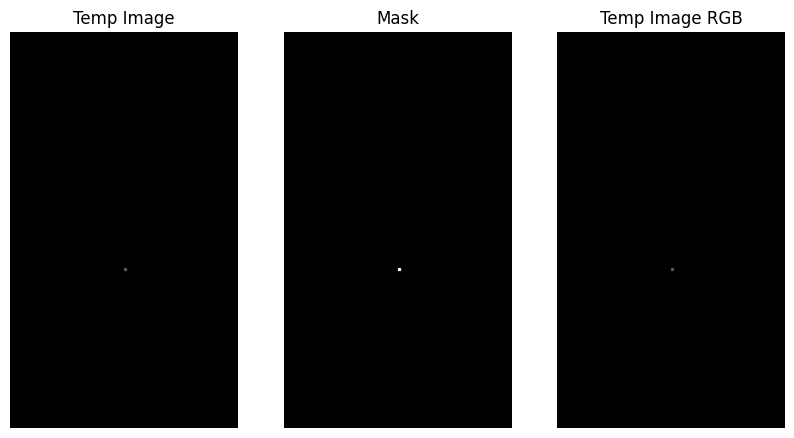

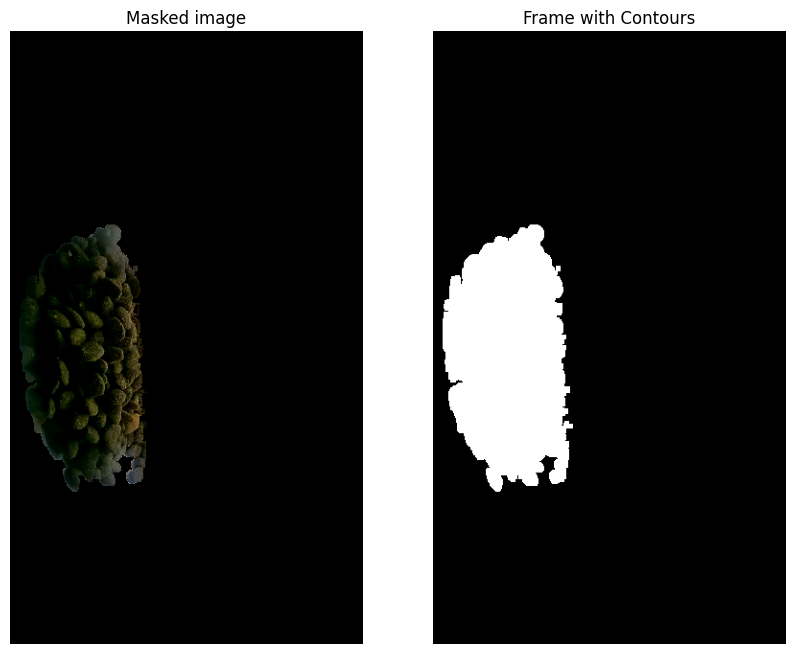

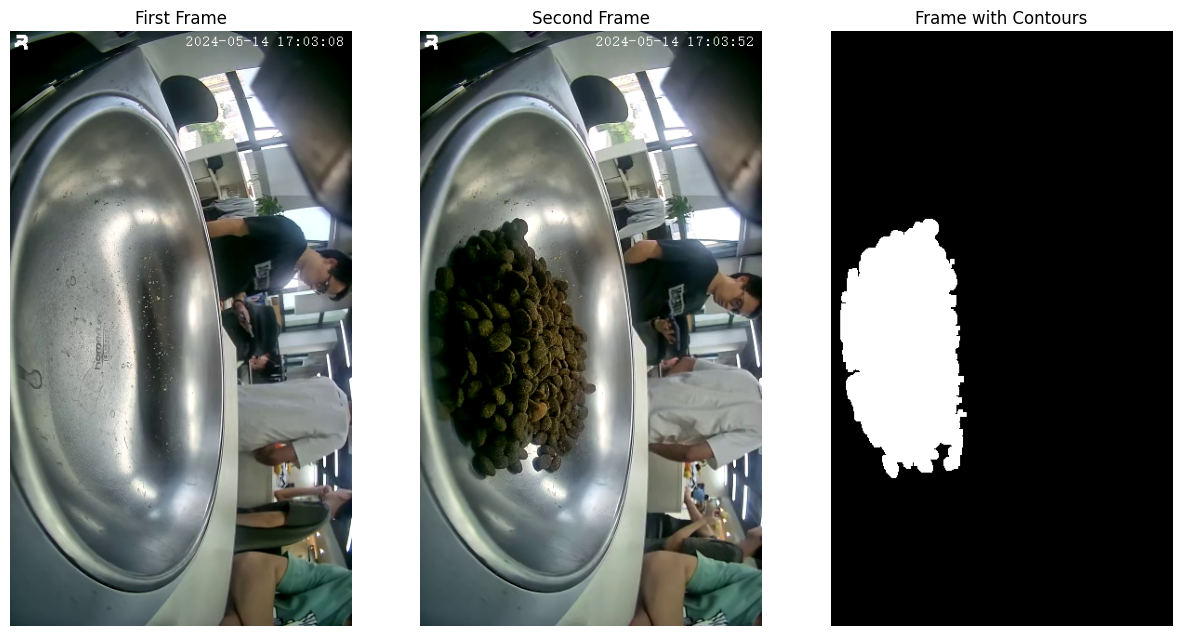

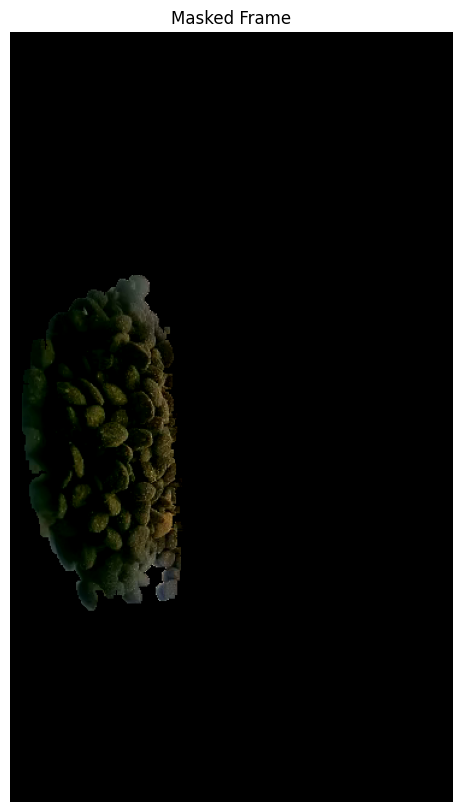

1.0443787574768066


In [24]:

def diff_image(f1, f2, mask=None):
    
    temp_f1 = f1.copy()
    temp_f2 = f2.copy()

    if mask is not None:
        temp_f1 = cv2.bitwise_and(temp_f1, temp_f1, mask=mask)
        temp_f2 = cv2.bitwise_and(temp_f2, temp_f2, mask=mask)


    frame1 = cv2.cvtColor(temp_f1.copy(), cv2.COLOR_BGR2GRAY)
    frame2 = cv2.cvtColor(temp_f2.copy(), cv2.COLOR_BGR2GRAY)
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(f1)
    plt.axis('off')
    plt.title('Frame 1')
    plt.subplot(1, 3, 2)
    plt.imshow(f2)
    plt.axis('off')
    plt.title('Frame 2')
    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()

    frame3 = cv2.absdiff(frame1, frame2)
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(frame3, cmap='gray')
    plt.axis('off')
    plt.title('Frame 3')

    _, thresh = cv2.threshold(frame3, 60, 255, cv2.THRESH_BINARY)
    plt.subplot(1, 3, 2)
    plt.imshow(thresh, cmap='gray')
    plt.axis('off')
    plt.title('Thresholded Frame Difference')



    # 可选：应用形态学操作以减少噪声
    kernel = np.ones((5, 5), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    plt.subplot(1, 3, 3)
    plt.imshow(thresh, cmap='gray')
    plt.axis('off')
    plt.title('Thresholded Frame Difference (After Morphology)')


    plt.show()

    # 查找轮廓
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 找到最大连通域
    # 查找前五个最大的轮廓
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    # 将这些轮廓变成mask
    masks = []
    for contour in contours:
        mask = np.zeros(frame1.shape, np.uint8)
        cv2.drawContours(mask, [contour], 0, 255, -1)
        temp_image = cv2.bitwise_and(f2, f2, mask=mask)
        # 统计temp_image的颜色分布
        rgb_hist = []
        for i in range(3):
            rgb_hist.append(cv2.calcHist([temp_image], [i], mask, [8], [0, 256]).astype(np.uint32))
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 3, 1)
        plt.imshow(temp_image)
        plt.axis('off')
        plt.title('Temp Image')
        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
        plt.title('Mask')
        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Temp Image RGB')
        plt.show()
        if all([rgb_hist[0][i] >= 1.2 * rgb_hist[2][i] and rgb_hist[1][i] >= 1.2 * rgb_hist[2][i] for i in range(3, 8)]):
            masks.append(mask)

    # 合并这些mask
    mask = np.zeros(frame1.shape, np.uint8)
    for m in masks:
        mask = cv2.bitwise_or(mask, m)
    # 使用mask将第二帧抠出来
    masked_frame2 = cv2.bitwise_and(f2, f2, mask=mask)

    # return masked_frame2
    # 显示抠出来的帧
    

    # 显示mask
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(masked_frame2 )
    plt.axis('off')
    plt.title('Masked image')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title('Frame with Contours')
    plt.show()
    max_contour = max(contours, key=cv2.contourArea)

    # 将最大连通域转换程mask
    mask = np.zeros(frame1.shape, np.uint8)
    cv2.drawContours(mask, [max_contour], 0, 255, -1)

    # 显示原始帧和带有轮廓的帧
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 3, 1)
    plt.title('First Frame')
    plt.imshow(f1)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(f2)
    plt.axis('off')
    plt.title('Second Frame')
    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title('Frame with Contours')
    plt.show()


    # 使用mask将第二帧抠出来
    masked_frame = cv2.bitwise_and(f2, f2, mask=mask)
    # 显示抠出来的帧
    plt.figure(figsize=(10, 10))
    plt.imshow(masked_frame)
    plt.axis('off')
    plt.title('Masked Frame')
    plt.show()

import time

now = time.time()
mask = cv2.imread('1715676001789.jpg', cv2.IMREAD_GRAYSCALE)
diff_image(frame1, frame2, mask)
duration = time.time() - now
# print second
print(duration)

C:\Users\dyj\AppData\Local\Temp\ipykernel_36552\2435985358.py:36: RuntimeWarning: invalid value encountered in cast
  hsv_mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)


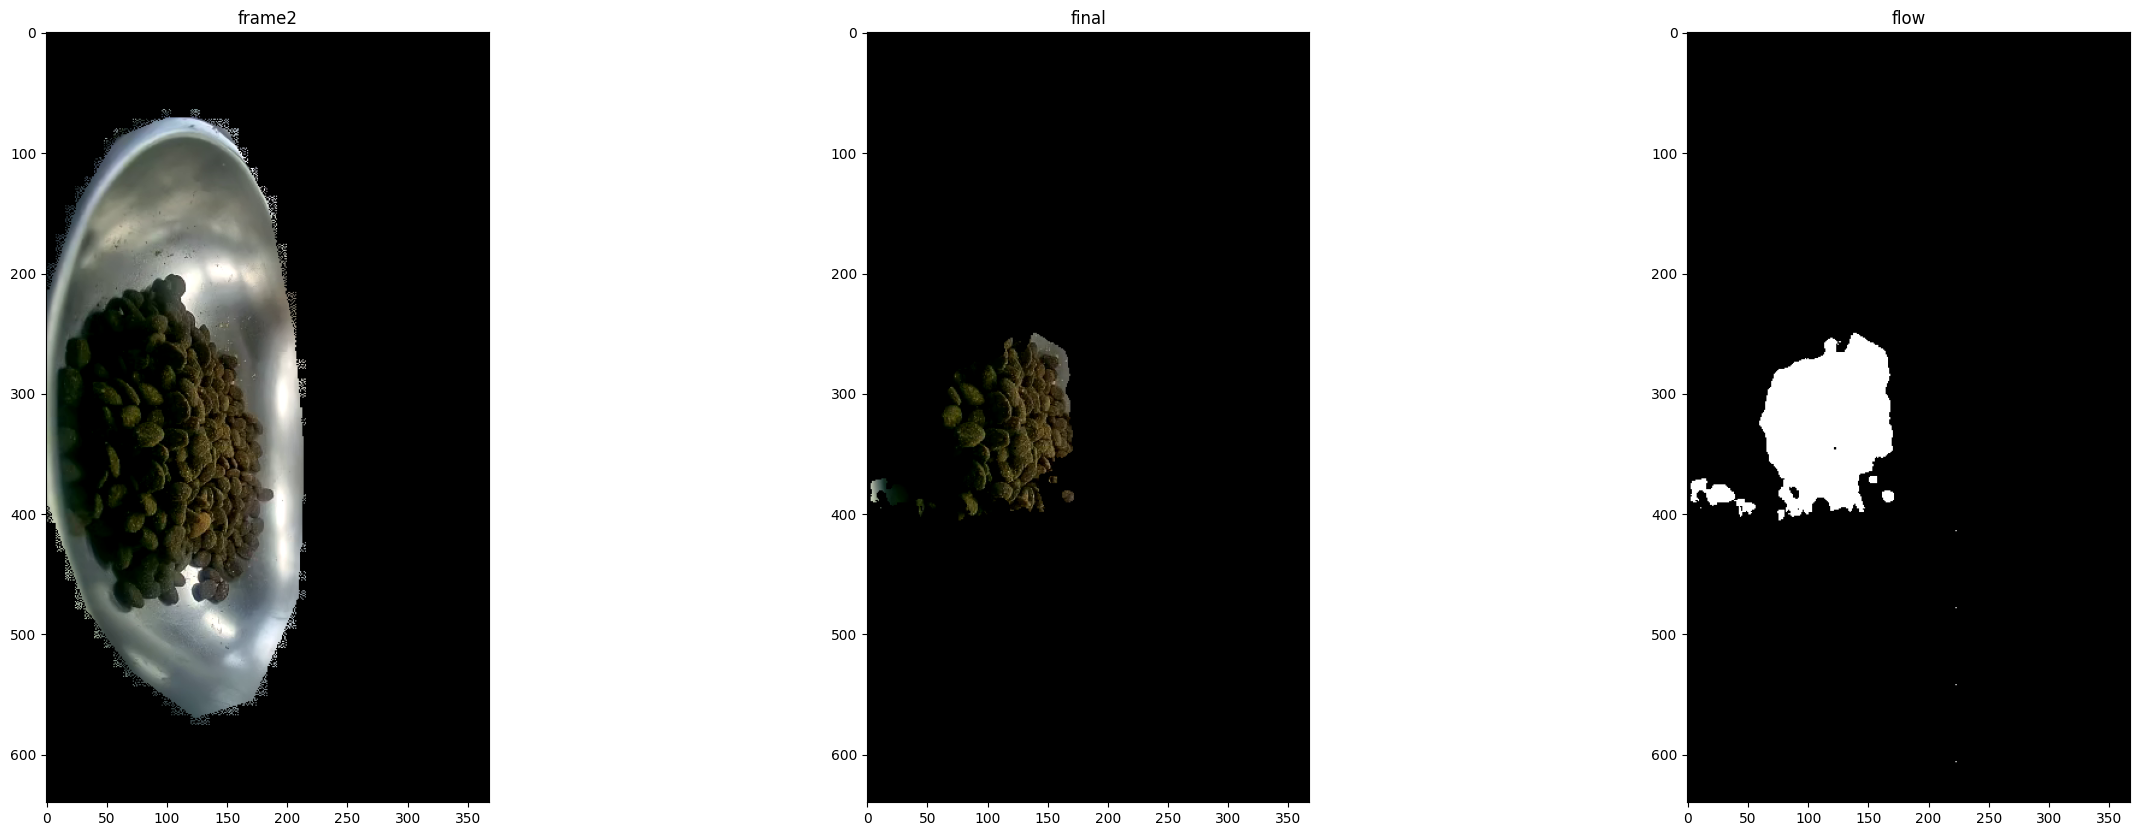

In [79]:
def use_polar(f1, f2, mask=None):
    import cv2
    import numpy as np

    # 读取前后两帧图片
    if mask is not None:
        frame1 = cv2.bitwise_and(f1, f1, mask=mask)
        frame2 = cv2.bitwise_and(f2, f2, mask=mask)

    # 将图片转换为灰度图像
    prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    # 计算光流
    flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, winsize = 5, iterations = 5, poly_n = 7, poly_sigma = 1.5, flags = 0)

    # 创建一个掩码用于绘制光流
    hsv_mask = np.zeros_like(frame1)
    hsv_mask[..., 1] = 255

    # 解码光流信息
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # 设置阈值，找出变化比较大的区域
    threshold = 80  # 你可以根据实际情况调整阈值
    mask = magnitude > threshold
    mask = mask.astype(np.uint8) * 255
    final = cv2.bitwise_and(frame2, frame2, mask=mask)
    # final[np.where(final == [0, 0, 0])] = 255

    hsv_mask[mask > 0] = [0, 255, 255]
    # 将角度转换为颜色
    hsv_mask[..., 0] = angle * 180 / np.pi / 2

    # 将幅值（速度）缩放到[0, 255]
    hsv_mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

    # 将HSV空间转换回BGR空间
    rgb = cv2.cvtColor(hsv_mask, cv2.COLOR_HSV2BGR)

    # 显示结果
    plt.figure(figsize=(30, 10))
    plt.subplot(1, 3, 1)
    
    plt.imshow(frame2)
    plt.title('frame2')
    
    plt.subplot(1, 3, 2)
    plt.imshow(final)
    plt.title('final')

    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.title('flow')
    plt.show()


use_polar(frame1, frame2, mask)


In [25]:
def diff_image_for_video(f1, f2, mask=None):
    
    temp_f1 = f1.copy()
    temp_f2 = f2.copy()

    if mask is not None:
        temp_f1 = cv2.bitwise_and(temp_f1, temp_f1, mask=mask)
        temp_f2 = cv2.bitwise_and(temp_f2, temp_f2, mask=mask)


    frame1 = cv2.cvtColor(temp_f1.copy(), cv2.COLOR_BGR2GRAY)
    frame2 = cv2.cvtColor(temp_f2.copy(), cv2.COLOR_BGR2GRAY)
    
    frame3 = cv2.absdiff(frame1, frame2)

    _, thresh = cv2.threshold(frame3, 60, 255, cv2.THRESH_BINARY)

    # 可选：应用形态学操作以减少噪声
    kernel = np.ones((5, 5), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # 查找轮廓
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 找到最大连通域
    # 查找前五个最大的轮廓
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    # 将这些轮廓变成mask
    masks = []
    for contour in contours:
        mask = np.zeros(frame1.shape, np.uint8)
        cv2.drawContours(mask, [contour], 0, 255, -1)
        temp_image = cv2.bitwise_and(f2, f2, mask=mask)
        # 统计temp_image的颜色分布
        rgb_hist = []
        for i in range(3):
            rgb_hist.append(cv2.calcHist([temp_image], [i], mask, [8], [16, 256]).astype(np.uint32))
        if all([rgb_hist[0][i] >= 1.2 * rgb_hist[2][i] and rgb_hist[1][i] >= 1.2 * rgb_hist[2][i] for i in range(3, 8)]):
            masks.append(mask)

    # 合并这些mask
    mask = np.zeros(frame1.shape, np.uint8)
    for m in masks:
        mask = cv2.bitwise_or(mask, m)
    # 使用mask将第二帧抠出来
    masked_frame2 = cv2.bitwise_and(f2, f2, mask=mask)

    return masked_frame2, mask

In [26]:
def calculate_ratio(r, g, b):
    if b > (r - 10):
        return 0, 0
    if b > ((r+g) / 2 - 10):
        return 0, 0
    if max([r,g,b]) - min([r,g,b]) < 35:
        return 0, 0
    ratio = max(min(r - g, 17) + 3, 0) / 20
    return ratio, 1 - ratio


def get_color_mask(ori_image_with_mask):
    new_image = np.zeros_like(ori_image_with_mask)
    mask_new_image = np.zeros_like(ori_image_with_mask)
    for row in range(ori_image_with_mask.shape[0]):
        for col in range(ori_image_with_mask.shape[1]):
            r, g, b = list(map(lambda x : int(x),[ori_image_with_mask[row,col,0],ori_image_with_mask[row,col,1],ori_image_with_mask[row,col,2]]))
            
            r_part = r * calculate_ratio(r, g, b)[0]
            g_part = g * calculate_ratio(r, g, b)[1]
            new_image[row, col, 2] = max(0, min(255, int(r_part + g_part)))
            new_image[row, col, 1] = max(0, min(255, int(g_part)))
            new_image[row, col, 0] = max(0, min(255, int(r_part)))
            if max(0, min(255, int(r_part + g_part))) > 20:
                mask_new_image[row, col, 0] = 255
    return mask_new_image[:,:,0]

def get_std_mask(ori_image_with_mask):
    ori_image_std = np.copy(ori_image_with_mask)
    ori_image_std[:,:,0] = (ori_image_std[:,:,0] * 1.2).astype(np.uint8)
    ori_image_std[:,:,1] = (ori_image_std[:,:,1] * 1.2).astype(np.uint8)
    ori_image_std[:,:,2] = (ori_image_std[:,:,2] * 0.6).astype(np.uint8)
    img_sum = np.sum(ori_image_std, axis=2)
    std_img = np.std(ori_image_std, axis=2)
    
    std_img = np.where(std_img<3, 0, 255)
    std_img = std_img.astype(np.uint8)
    return std_img

def get_final_mask(mask_new_image, std_img):
    final_mask = np.zeros_like(mask_new_image)
    for i in range(final_mask.shape[0]):
        for j in range(final_mask.shape[1]):
            if std_img[i,j] > 0 and mask_new_image[i,j]>0 :
                final_mask[i,j] = 255
    return final_mask

# 求自适应阈值的最小和最大值
def GetMatMinMaxThreshold(img, sigma=0.2):
    midval = np.median(img)
    # 计算低阈值
    minval = int((1.0 - sigma) * midval)
    # 计算高阈值
    maxval = int((1.0 + sigma) * midval)
    return minval ,maxval

def get_rect_image(image1, final_mask, rgb=0):
    image1_GaussianBlur = cv2.GaussianBlur(image1, (5,5), 0)
    image1_GaussianBlur = cv2.GaussianBlur(image1_GaussianBlur, (5,5), 0)

    i = rgb
    image_single_channel = image1_GaussianBlur[:,:,i]
    minval, maxval = GetMatMinMaxThreshold(image_single_channel)   
    Canny2_image_single_channel=cv2.Canny(image_single_channel,minval,maxval) 
    # Canny2_image_single_channel = cv2.bitwise_and(Canny2_image_single_channel, Canny2_image_single_channel, mask=mask_new_image[:,:,0])
    
    # Canny2_image_single_channel = cv2.bitwise_and(Canny2_image_single_channel, Canny2_image_single_channel, mask=std_img)
    Canny2_image_single_channel = cv2.bitwise_and(Canny2_image_single_channel, Canny2_image_single_channel, mask=final_mask)
    contours, hierarchy = cv2.findContours(Canny2_image_single_channel, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # 将这些contours变成一个mask
    final_mask = np.zeros(image1.shape[:2], np.uint8)
    for contour in contours:
        mask = np.zeros(image1.shape[:2], np.uint8)

        # 找到边界坐标
        x, y, w, h = cv2.boundingRect(contour)  # 计算点集最外面的矩形边界
        mask[y:y+h, x:x+w] = 255
        
        final_mask = cv2.bitwise_or(final_mask, mask)
    
    return final_mask


def get_cat_food(frame, bowl_mask):
    image = frame

    frame_after_bowl_mask = cv2.bitwise_and(image, image, mask=bowl_mask)

    std_mask = get_std_mask(frame_after_bowl_mask)
    color_mask = get_color_mask(frame_after_bowl_mask)
    final_mask = get_final_mask(color_mask, std_mask)
    rect_frame = get_rect_image(frame_after_bowl_mask, final_mask)
    return rect_frame

In [28]:
final_frames = []
start = time.time()
for frame in frames:
    mask1 = diff_image_for_video(frame1, frame, mask)[1]
    mask2 = get_cat_food(frame, mask)

    final_mask = cv2.bitwise_or(mask1, mask2)
    frame = cv2.bitwise_and(frame, frame, mask=final_mask)
    final_frames.append([frame, mask1, mask2])
print((time.time() - start)/len(frames))

h, w, c = final_frames[0][0].shape
# save frames into one video
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter('output7.avi', fourcc, 1.0, (w*4, h))
for ori, dst in zip(frames, final_frames):
    temp = np.zeros((h, w*4, c), dtype=np.uint8)
    temp[:, :w, :] = ori
    temp[:, w:2*w, :] = dst[0]
    temp[:, 2*w:3*w, :] = np.stack([dst[1], dst[1], dst[1]], axis=-1)
    temp[:, 3*w:, :] = np.stack([dst[2], dst[2], dst[2]], axis=-1)
    temp = cv2.cvtColor(temp, cv2.COLOR_RGB2BGR)
    video.write(temp)
video.release()
    
    


0.8202445793151856
